In [ ]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_UN= pd.read_csv('gdrive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M= pd.read_csv('gdrive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W= pd.read_csv('gdrive/My Drive/DL Project/Waitakere/Waitakere_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
dataset = df_UN

In [ ]:
#dataset.drop(['Level (mean)', 'Rainfall (NiWa)','Spill'], axis=1, inplace=True)

In [ ]:
dataset['Level'] = dataset['Level'].interpolate(method='slinear').interpolate(method='linear')
dataset['Spill (m)'] = dataset['Spill'].interpolate(method='slinear').interpolate(method='linear')

### Rainfall shift

In [ ]:
shift_rain = 3

In [ ]:
dataset[f'Rainfall +{shift_rain}'] = dataset['Rainfall (WSL)'].shift(shift_rain)

In [ ]:
dataset = dataset[shift_rain:]

In [ ]:
dataset.head()

,Level,Spill,Rainfall (WSL),Abstraction,Compensation,Rainfall (NIWA),Soil Moisture,Max Temp,Penman Evaporation,Vapour Pressure,Solar Radiation,Year sin,Year cos
Date,,,,,,,,,,,,,
2009-01-01,52.137,0.0,2.35,124727.625,15000.0,2.5,-77.3,25.5,3.2,21.2,14.8,0.0172,0.9999
2009-01-02,52.094,0.0,7.99,125076.500,15000.0,11.2,-72.4,25.1,4.5,20.8,16.6,0.0344,0.9994
2009-01-03,52.057,0.0,13.63,124547.250,15000.0,0.0,-77.4,21.9,6.0,12.5,31.9,0.0516,0.9987
2009-01-04,52.013,0.0,0.00,125002.000,15000.0,0.0,-81.4,22.7,5.1,14.1,28.4,0.0688,0.9976
2009-01-05,51.958,0.0,0.00,125034.875,15000.0,0.0,-84.6,22.9,5.5,15.0,29.9,0.0859,0.9963


### **Seasonal Periodicity**

Adding 'Day' column as an input feature to account for seasonality.

Hydrometric data has clear daily, monthly and yearly periodicity.

A simple approach to convert it to a usable signal is to use sine and cos to convert the time to clear "Time of month" and "Time of year" signals:

In [ ]:
dataset['Day'] = dataset.index.dayofyear

In [ ]:
_day = dataset['Day']

In [ ]:
dataset = dataset.drop(['Day'], axis=1)

In [ ]:
month = 365.2425#/12
year = (365.2425)

dataset['Year sin'] = np.sin(_day * (2 * np.pi / month))
dataset['Year cos'] = np.cos(_day * (2 * np.pi / month))

Text(0.5, 1.0, 'Time of Year signal')

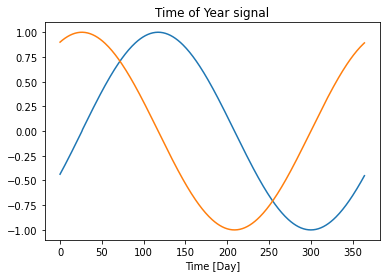

In [ ]:
plt.plot(np.array(dataset['Year sin'])[:365])
plt.plot(np.array(dataset['Year cos'])[:365])
plt.xlabel('Time [Day]')
plt.title('Time of Year signal')

## **Split Data**

In [ ]:
X = dataset.iloc[:,1:]

In [ ]:
X.head()

,Spill,Rainfall (NiWa),Rainfall (WSL),Vapour Pressure (hPa),Observed Penman Evaporation,Abstraction (m3),Compensation (m3),Max Temp,Soil Moisture,Solar Radiation,Year sin,Year cos
Date,,,,,,,,,,,,
2009-12-02,0.0000,34.3,27.0,18.4,3.0,24724.750,8613.3179,20.8,-42.6,15.6,-0.4821,0.8761
2009-12-03,0.0000,57.6,1.5,15.5,1.6,24767.125,8614.2857,15.9,-9.3,5.3,-0.4670,0.8843
2009-12-04,0.0000,0.0,74.5,14.8,4.1,24923.500,8299.3370,19.9,-24.7,24.1,-0.4517,0.8922
2009-12-05,0.0869,1.5,0.5,15.4,4.2,25558.875,8270.9324,20.6,-27.2,26.3,-0.4363,0.8998
2009-12-06,0.0135,0.0,0.0,14.1,5.5,25590.750,8268.8724,19.3,-31.6,26.9,-0.4207,0.9072


In [ ]:
y = dataset.iloc[:,0]

In [ ]:
y.head()

Date
2009-12-02    29.792
2009-12-03    29.857
2009-12-04    33.142
2009-12-05    33.858
2009-12-06    33.805
Name: Level, dtype: float64

In [ ]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [ ]:
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

In [ ]:
grid_search

## **Fit Model**

[04:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.04410721 0.00563894 0.         0.         0.         0.0396025
 0.3019553  0.00889488 0.40576786 0.         0.13556692 0.05846643]


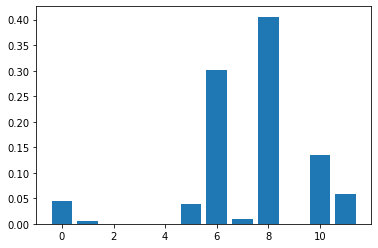

In [ ]:
# fit model no training data
model = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.001)
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

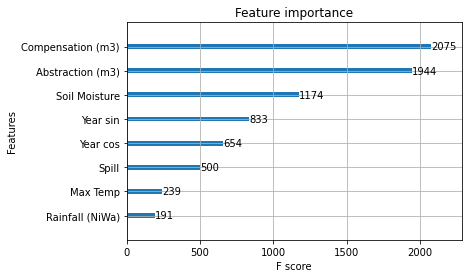

In [ ]:
plot_importance(model)
pyplot.show()

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 20.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491614 sha256=0cef795995a37e72117d5eace39b7cbf49615771f67a18abdffb4908202afc7b
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

In [ ]:
model2 = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)# Fit the Model
model2.fit(X, y)

[20:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X)

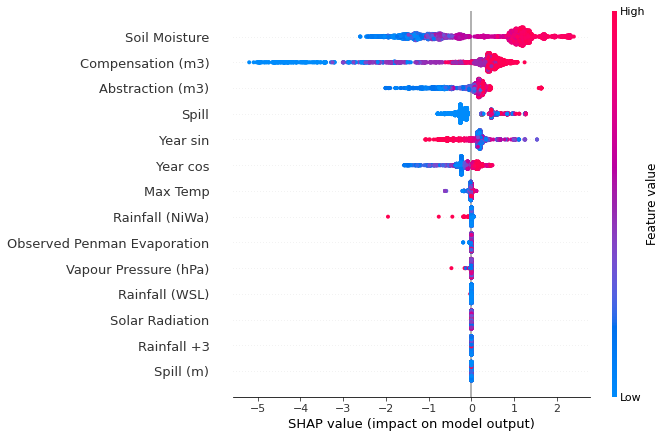

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

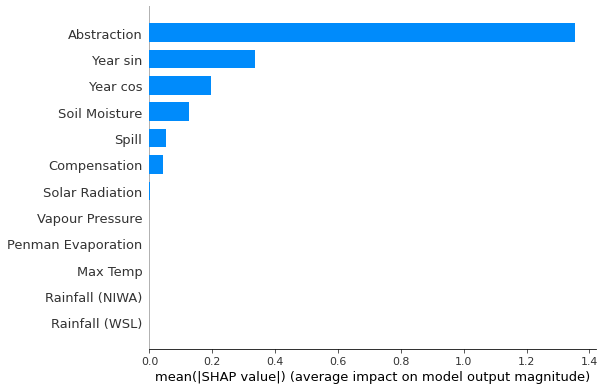

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type= 'bar')